# 🧪 Prompt Testing Playground

> **An interactive tool for testing, comparing, and visualizing LLM prompts across multiple models**

---

## ✨ Features

| Feature | Description |
|---------|-------------|
| 🔍 **Multi-Prompt Comparison** | Test multiple prompts side-by-side to find the best phrasing |
| 🤖 **Multi-Model Support** | Compare outputs across GPT-4o-mini, GPT-4.1-mini, GPT-3.5-turbo, and GPT-4o |
| 📊 **Token Probability Visualization** | See how the model predicts each token with probability heatmaps |
| 📈 **Metrics Dashboard** | Analyze confidence, perplexity, entropy, and uncertainty |
| 🎨 **Interactive UI** | Built with Gradio for easy experimentation |

---

## 🎯 Use Cases

<table>
<tr>
<td width="50%">

**🔧 Prompt Engineering**
- Optimize prompt phrasing
- A/B test variations
- Reduce ambiguity

</td>
<td width="50%">

**🎓 Education**
- Learn how LLMs work
- Visualize token predictions
- Understand temperature effects

</td>
</tr>
<tr>
<td width="50%">

**⚖️ Model Selection**
- Compare model performance
- Balance cost vs. quality
- Benchmark different models

</td>
<td width="50%">

**🔬 Research**
- Analyze model uncertainty
- Study token-level predictions
- Export data for analysis

</td>
</tr>
</table>

---

**💡 Inspired by:** Week 3's `visualizer.py` - extending token prediction concepts

**👨‍💻 Author:** dc_dalin | **📅 Week:** 3

---

## 📦 Setup and Installation

> Make sure you have the required packages installed and your OpenAI API key configured

In [8]:
# 📥 Install required packages (uncomment if needed)
# !pip install -q openai python-dotenv gradio matplotlib networkx pandas numpy

print("💡 If running on Google Colab, uncomment the line above to install dependencies")

💡 If running on Google Colab, uncomment the line above to install dependencies


In [9]:
# ========================================
# 📚 Import Required Libraries
# ========================================

import os
import sys
import math
import json
from pathlib import Path
from typing import List, Dict, Tuple
from datetime import datetime

# Data science libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

# Web UI and API
import gradio as gr
from openai import OpenAI
from dotenv import load_dotenv

# ========================================
# 🔧 Environment Setup
# ========================================

# Load environment from parent directory
project_root = Path.cwd().parent.parent.parent
env_path = project_root / '.env'
load_dotenv(env_path, override=True)

# Initialize OpenAI client
client = OpenAI()

# ========================================
# ✅ Verification
# ========================================

print("=" * 60)
print("🎯 PROMPT TESTING PLAYGROUND - INITIALIZATION")
print("=" * 60)
print(f"✅ Environment loaded from: {env_path}")
print(f"✅ OpenAI client initialized")
print(f"✅ All dependencies imported successfully")
print("=" * 60)

🎯 PROMPT TESTING PLAYGROUND - INITIALIZATION
✅ Environment loaded from: /Users/dc_dalin/Projects/llm_engineering/.env
✅ OpenAI client initialized
✅ All dependencies imported successfully


---

## 🧠 Core Classes: Token Prediction & Analysis

> The `TokenPredictor` class handles all token-by-token prediction and metrics calculation

In [10]:
class TokenPredictor:
    """Enhanced token predictor with detailed probability analysis."""
    
    def __init__(self, model_name: str = "gpt-4o-mini"):
        self.client = OpenAI()
        self.model_name = model_name
    
    def predict_tokens(self, prompt: str, max_tokens: int = 100, temperature: float = 0.7) -> Dict:
        """
        Generate text token by token and track prediction probabilities.
        Returns detailed prediction data including metrics.
        """
        response = self.client.chat.completions.create(
            model=self.model_name,
            messages=[{"role": "user", "content": prompt}],
            max_tokens=max_tokens,
            temperature=temperature,
            logprobs=True,
            seed=42,
            top_logprobs=5,  # Get top 5 alternative tokens
            stream=True,
        )
        
        predictions = []
        full_text = ""
        
        for chunk in response:
            if chunk.choices[0].delta.content:
                token = chunk.choices[0].delta.content
                full_text += token
                
                logprobs = chunk.choices[0].logprobs.content[0].top_logprobs
                logprob_dict = {item.token: item.logprob for item in logprobs}
                
                # Get top predicted token and probability
                top_token = token
                top_logprob = logprob_dict[token]
                top_prob = math.exp(top_logprob)
                
                # Get alternative predictions
                alternatives = []
                for alt_token, alt_logprob in logprob_dict.items():
                    if alt_token != token:
                        alternatives.append({
                            "token": alt_token,
                            "probability": math.exp(alt_logprob),
                            "logprob": alt_logprob
                        })
                
                alternatives.sort(key=lambda x: x["probability"], reverse=True)
                
                prediction = {
                    "token": top_token,
                    "probability": top_prob,
                    "logprob": top_logprob,
                    "alternatives": alternatives[:4],  # Keep top 4 alternatives
                }
                predictions.append(prediction)
        
        # Calculate metrics
        metrics = self._calculate_metrics(predictions)
        
        return {
            "prompt": prompt,
            "model": self.model_name,
            "temperature": temperature,
            "generated_text": full_text,
            "predictions": predictions,
            "metrics": metrics,
            "timestamp": datetime.now().isoformat()
        }
    
    def _calculate_metrics(self, predictions: List[Dict]) -> Dict:
        """Calculate various metrics from token predictions."""
        if not predictions:
            return {}
        
        probabilities = [p["probability"] for p in predictions]
        logprobs = [p["logprob"] for p in predictions]
        
        # Average confidence (mean probability)
        avg_confidence = np.mean(probabilities)
        
        # Perplexity: exp(-mean(log_probs))
        perplexity = math.exp(-np.mean(logprobs))
        
        # Entropy: measure of uncertainty
        entropies = []
        for pred in predictions:
            probs = [pred["probability"]] + [alt["probability"] for alt in pred["alternatives"]]
            # Normalize probabilities
            probs = np.array(probs)
            probs = probs / probs.sum()
            # Calculate entropy
            entropy = -np.sum(probs * np.log2(probs + 1e-10))
            entropies.append(entropy)
        
        avg_entropy = np.mean(entropies)
        
        # Low confidence tokens (probability < 0.5)
        low_confidence_tokens = sum(1 for p in probabilities if p < 0.5)
        low_confidence_pct = (low_confidence_tokens / len(probabilities)) * 100
        
        return {
            "token_count": len(predictions),
            "avg_confidence": round(avg_confidence, 4),
            "perplexity": round(perplexity, 4),
            "avg_entropy": round(avg_entropy, 4),
            "low_confidence_tokens": low_confidence_tokens,
            "low_confidence_pct": round(low_confidence_pct, 2),
            "min_probability": round(min(probabilities), 4),
            "max_probability": round(max(probabilities), 4)
        }

---

## 📊 Visualization Functions

> Create beautiful visualizations for token probabilities, alternatives, and metrics comparisons

In [11]:
def create_probability_heatmap(prediction_data: Dict) -> plt.Figure:
    """Create a heatmap showing token probabilities over time."""
    predictions = prediction_data["predictions"]
    
    if not predictions:
        fig, ax = plt.subplots(figsize=(10, 2))
        ax.text(0.5, 0.5, 'No predictions available', ha='center', va='center')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.axis('off')
        return fig
    
    # Extract data
    tokens = [p["token"] for p in predictions]
    probabilities = [p["probability"] for p in predictions]
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), gridspec_kw={'height_ratios': [3, 1]})
    
    # Heatmap of probabilities
    colors = plt.cm.RdYlGn(probabilities)
    ax1.bar(range(len(tokens)), probabilities, color=colors, edgecolor='black', linewidth=0.5)
    ax1.set_ylabel('Probability', fontsize=12, fontweight='bold')
    ax1.set_title(f'Token Prediction Probabilities - {prediction_data["model"]}', 
                  fontsize=14, fontweight='bold', pad=20)
    ax1.set_ylim(0, 1)
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='50% threshold')
    ax1.legend()
    
    # Token labels (show every nth token to avoid crowding)
    step = max(1, len(tokens) // 20)
    ax1.set_xticks(range(0, len(tokens), step))
    ax1.set_xticklabels([tokens[i] for i in range(0, len(tokens), step)], 
                        rotation=45, ha='right', fontsize=8)
    
    # Generated text preview
    text = prediction_data["generated_text"]
    ax2.text(0.5, 0.5, f'Generated Text:\n"{text}"', 
             ha='center', va='center', fontsize=10, wrap=True,
             bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.3))
    ax2.set_xlim(0, 1)
    ax2.set_ylim(0, 1)
    ax2.axis('off')
    
    plt.tight_layout()
    return fig


def create_alternatives_plot(prediction_data: Dict, token_index: int = 0) -> plt.Figure:
    """Show alternative token predictions for a specific position."""
    predictions = prediction_data["predictions"]
    
    if not predictions or token_index >= len(predictions):
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.text(0.5, 0.5, 'No alternatives available', ha='center', va='center')
        ax.axis('off')
        return fig
    
    pred = predictions[token_index]
    
    # Prepare data
    tokens = [pred["token"]] + [alt["token"] for alt in pred["alternatives"]]
    probs = [pred["probability"]] + [alt["probability"] for alt in pred["alternatives"]]
    colors_list = ['green'] + ['orange'] * len(pred["alternatives"])
    
    # Create plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(tokens, probs, color=colors_list, edgecolor='black', linewidth=1.5)
    
    # Add probability labels
    for i, (bar, prob) in enumerate(zip(bars, probs)):
        ax.text(prob + 0.02, bar.get_y() + bar.get_height()/2, 
                f'{prob*100:.1f}%', va='center', fontweight='bold')
    
    ax.set_xlabel('Probability', fontsize=12, fontweight='bold')
    ax.set_ylabel('Token', fontsize=12, fontweight='bold')
    ax.set_title(f'Top Alternative Tokens at Position {token_index + 1}', 
                 fontsize=14, fontweight='bold', pad=20)
    ax.set_xlim(0, max(probs) * 1.2)
    ax.grid(True, alpha=0.3, axis='x')
    
    # Add legend
    ax.legend([bars[0], bars[1]], ['Selected Token', 'Alternative'], loc='lower right')
    
    plt.tight_layout()
    return fig


def create_metrics_comparison(results: List[Dict]) -> plt.Figure:
    """Compare metrics across multiple prompt/model combinations."""
    if not results:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.text(0.5, 0.5, 'No results to compare', ha='center', va='center')
        ax.axis('off')
        return fig
    
    # Extract metrics
    labels = [f"{r['model']}\n(T={r['temperature']})" for r in results]
    avg_conf = [r['metrics']['avg_confidence'] for r in results]
    perplexity = [r['metrics']['perplexity'] for r in results]
    avg_entropy = [r['metrics']['avg_entropy'] for r in results]
    
    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    # Average Confidence
    axes[0].bar(range(len(labels)), avg_conf, color='skyblue', edgecolor='black')
    axes[0].set_ylabel('Average Confidence', fontweight='bold')
    axes[0].set_title('Average Token Confidence', fontweight='bold')
    axes[0].set_xticks(range(len(labels)))
    axes[0].set_xticklabels(labels, fontsize=9)
    axes[0].set_ylim(0, 1)
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Perplexity (lower is better)
    axes[1].bar(range(len(labels)), perplexity, color='lightcoral', edgecolor='black')
    axes[1].set_ylabel('Perplexity', fontweight='bold')
    axes[1].set_title('Perplexity (Lower = Better)', fontweight='bold')
    axes[1].set_xticks(range(len(labels)))
    axes[1].set_xticklabels(labels, fontsize=9)
    axes[1].grid(True, alpha=0.3, axis='y')
    
    # Average Entropy
    axes[2].bar(range(len(labels)), avg_entropy, color='lightgreen', edgecolor='black')
    axes[2].set_ylabel('Average Entropy', fontweight='bold')
    axes[2].set_title('Average Entropy (Uncertainty)', fontweight='bold')
    axes[2].set_xticks(range(len(labels)))
    axes[2].set_xticklabels(labels, fontsize=9)
    axes[2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    return fig

---

## 🧪 Test the Core Functionality

> Let's test the token predictor with a sample prompt and see the visualizations in action!

In [12]:
# ========================================
# 🎯 Single Prompt Test
# ========================================

test_prompt = "In one sentence, describe the color orange to someone who has never been able to see."

print("🔄 Generating predictions...")
predictor = TokenPredictor("gpt-4o-mini")
result = predictor.predict_tokens(test_prompt, max_tokens=50)

print("\n" + "=" * 80)
print("📝 PROMPT ANALYSIS RESULTS")
print("=" * 80)
print(f"\n💬 Prompt: {test_prompt}")
print(f"\n✨ Generated Text: {result['generated_text']}")
print(f"\n📊 Metrics:")
print("-" * 80)
for key, value in result['metrics'].items():
    print(f"   {key:.<30} {value}")
print("=" * 80)

🔄 Generating predictions...

📝 PROMPT ANALYSIS RESULTS

💬 Prompt: In one sentence, describe the color orange to someone who has never been able to see.

✨ Generated Text: Orange is the warm, vibrant sensation of sunlight on your skin mixed with the zesty tang of citrus, evoking feelings of energy and enthusiasm.

📊 Metrics:
--------------------------------------------------------------------------------
   token_count................... 29
   avg_confidence................ 0.7888
   perplexity.................... 1.3804
   avg_entropy................... 0.687
   low_confidence_tokens......... 5
   low_confidence_pct............ 17.24
   min_probability............... 0.1277
   max_probability............... 1.0


📊 Creating probability heatmap...


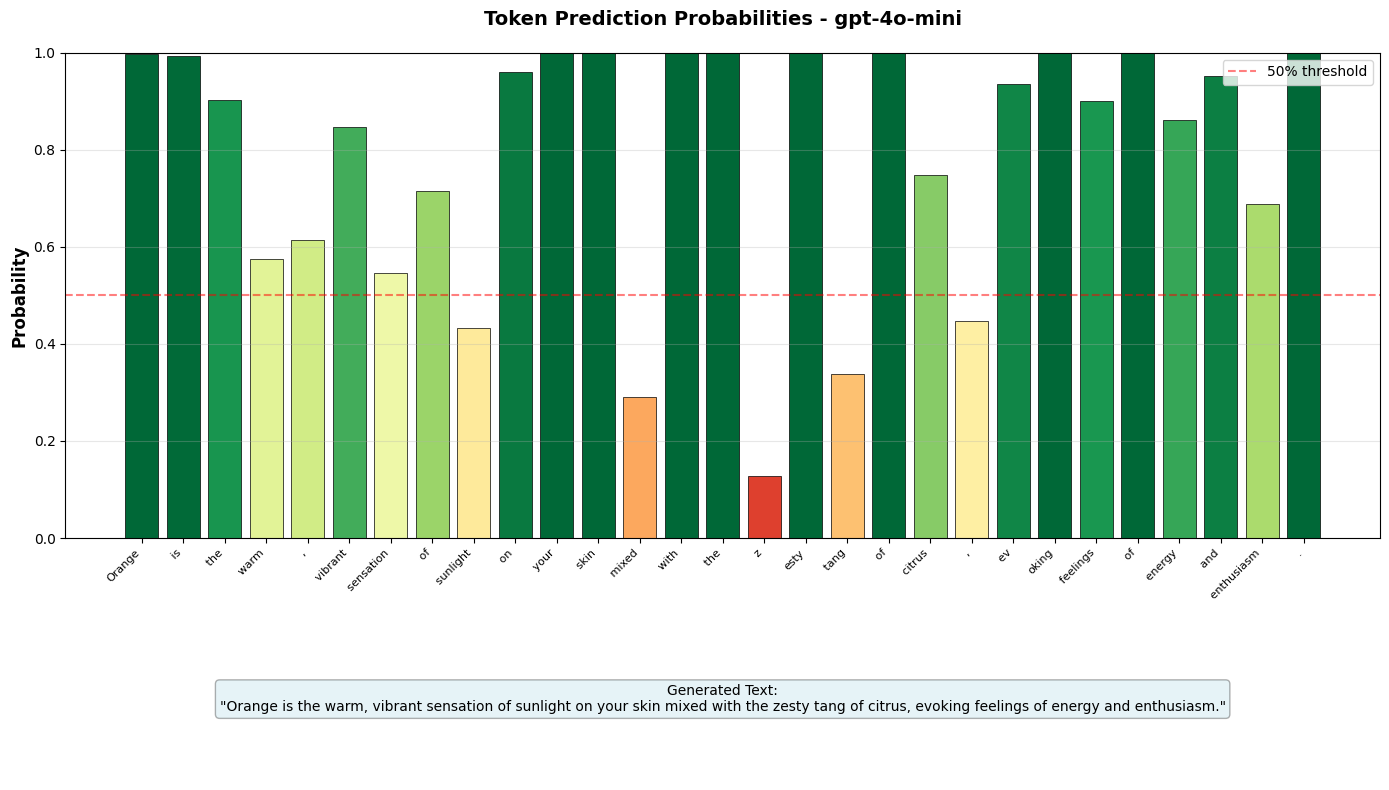

✅ Visualization complete!


In [13]:
# ========================================
# 📈 Probability Heatmap Visualization
# ========================================

print("📊 Creating probability heatmap...")
fig = create_probability_heatmap(result)
plt.show()
print("✅ Visualization complete!")

🔍 Showing alternative tokens for first 3 positions...

Position 1:


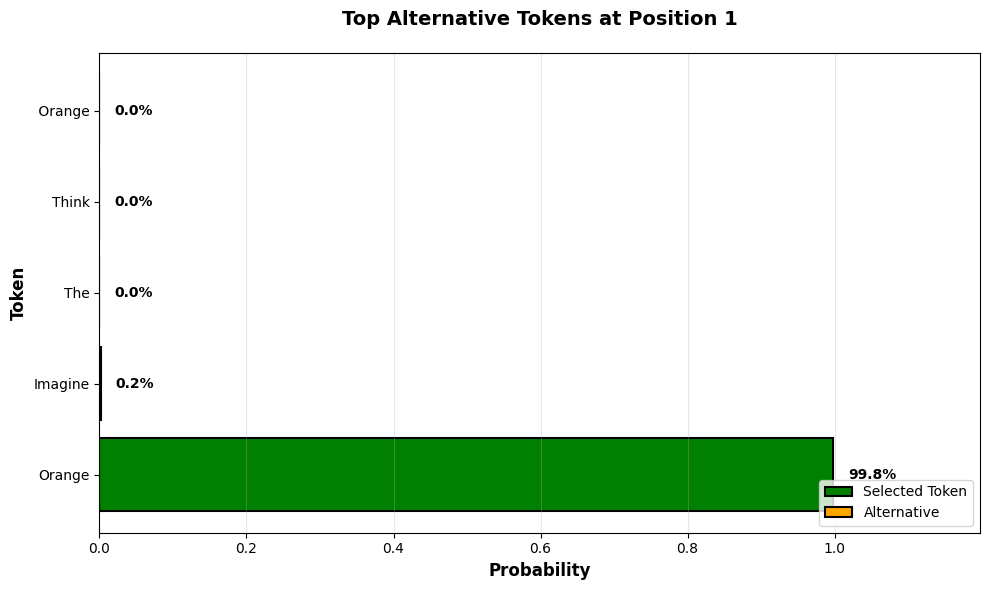

------------------------------------------------------------
Position 2:


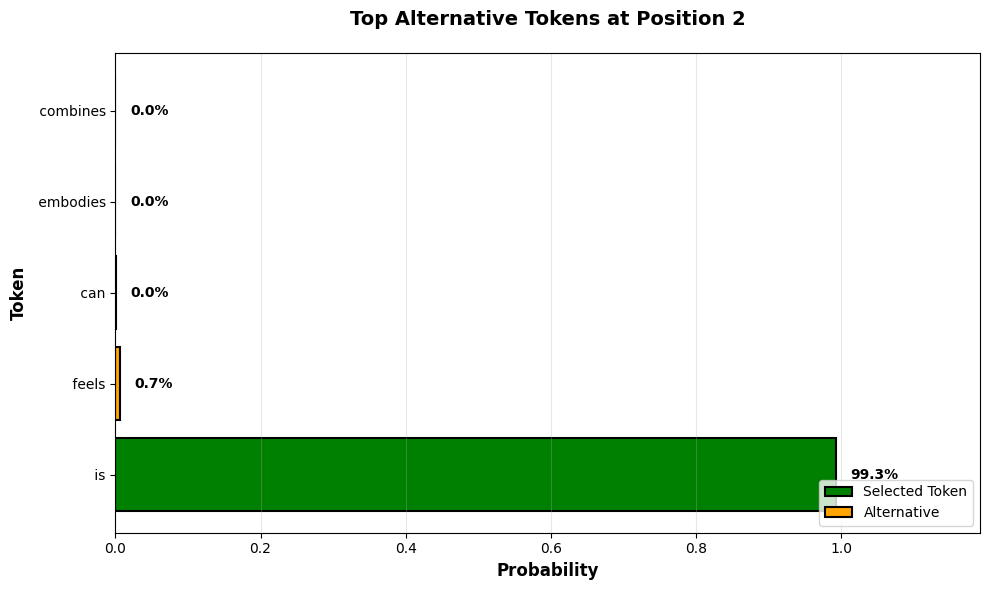

------------------------------------------------------------
Position 3:


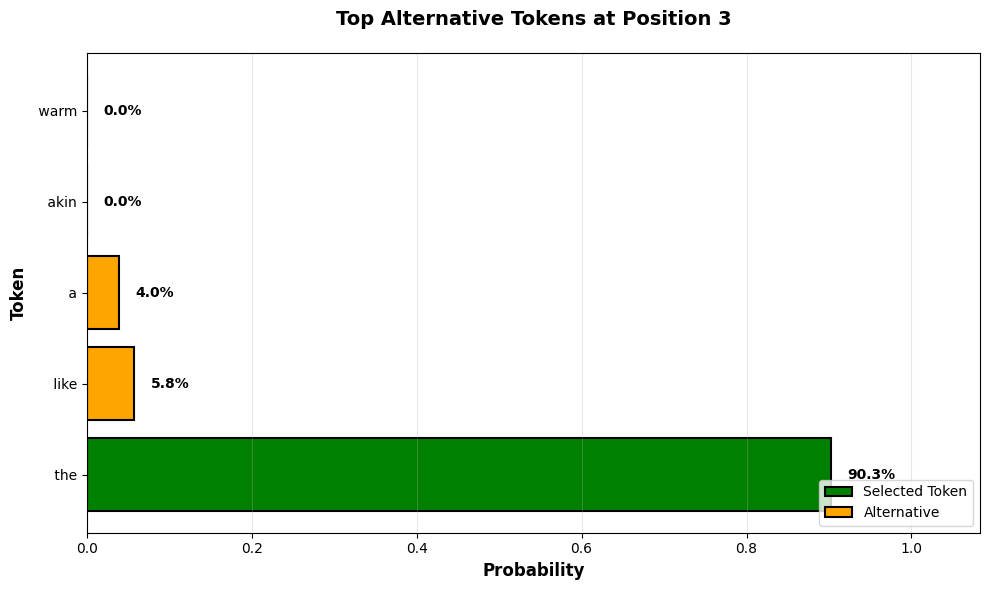

------------------------------------------------------------


In [14]:
# ========================================
# 🔀 Alternative Tokens Visualization
# ========================================

print("🔍 Showing alternative tokens for first 3 positions...\n")
for i in range(min(3, len(result['predictions']))):
    print(f"Position {i + 1}:")
    fig = create_alternatives_plot(result, token_index=i)
    plt.show()
    print("-" * 60)

---

## 🆚 Multi-Model & Multi-Prompt Comparison

> Compare different models or prompts to find the best option for your use case

In [15]:
def compare_models(prompt: str, models: List[str], max_tokens: int = 50, temperature: float = 0.7) -> List[Dict]:
    """Compare the same prompt across multiple models."""
    results = []
    
    for model in models:
        print(f"Testing {model}...")
        predictor = TokenPredictor(model)
        result = predictor.predict_tokens(prompt, max_tokens, temperature)
        results.append(result)
    
    return results


def compare_prompts(prompts: List[str], model: str = "gpt-4o-mini", 
                    max_tokens: int = 50, temperature: float = 0.7) -> List[Dict]:
    """Compare multiple prompts using the same model."""
    results = []
    predictor = TokenPredictor(model)
    
    for i, prompt in enumerate(prompts):
        print(f"Testing prompt {i+1}/{len(prompts)}...")
        result = predictor.predict_tokens(prompt, max_tokens, temperature)
        results.append(result)
    
    return results

In [16]:
# ========================================
# 🤖 Model Comparison Example
# ========================================

test_models = ["gpt-4o-mini", "gpt-4.1-mini"]

print("=" * 80)
print("🔬 COMPARING MODELS")
print("=" * 80)
print(f"📝 Prompt: {test_prompt}")
print(f"🤖 Models: {', '.join(test_models)}")
print("-" * 80)

model_results = compare_models(test_prompt, test_models, max_tokens=50)

# Display comparison
for result in model_results:
    print(f"\n{'='*80}")
    print(f"🤖 Model: {result['model']}")
    print(f"{'='*80}")
    print(f"✨ Generated: {result['generated_text']}")
    print(f"📊 Avg Confidence: {result['metrics']['avg_confidence']:.4f}")
    print(f"📊 Perplexity: {result['metrics']['perplexity']:.4f}")
    
print(f"\n{'='*80}")

🔬 COMPARING MODELS
📝 Prompt: In one sentence, describe the color orange to someone who has never been able to see.
🤖 Models: gpt-4o-mini, gpt-4.1-mini
--------------------------------------------------------------------------------
Testing gpt-4o-mini...
Testing gpt-4.1-mini...

🤖 Model: gpt-4o-mini
✨ Generated: Orange is the warm, vibrant sensation of sunlight on your skin mixed with the sweet, tangy taste of a ripe citrus fruit, evoking energy and enthusiasm.
📊 Avg Confidence: 0.8118
📊 Perplexity: 1.3055

🤖 Model: gpt-4.1-mini
✨ Generated: Orange is the warm, vibrant feeling of a gentle sunset on your skin, blending the energy of red's heat with the cheerful brightness of yellow's light.
📊 Avg Confidence: 0.7996
📊 Perplexity: 1.3423



📊 Creating metrics comparison chart...


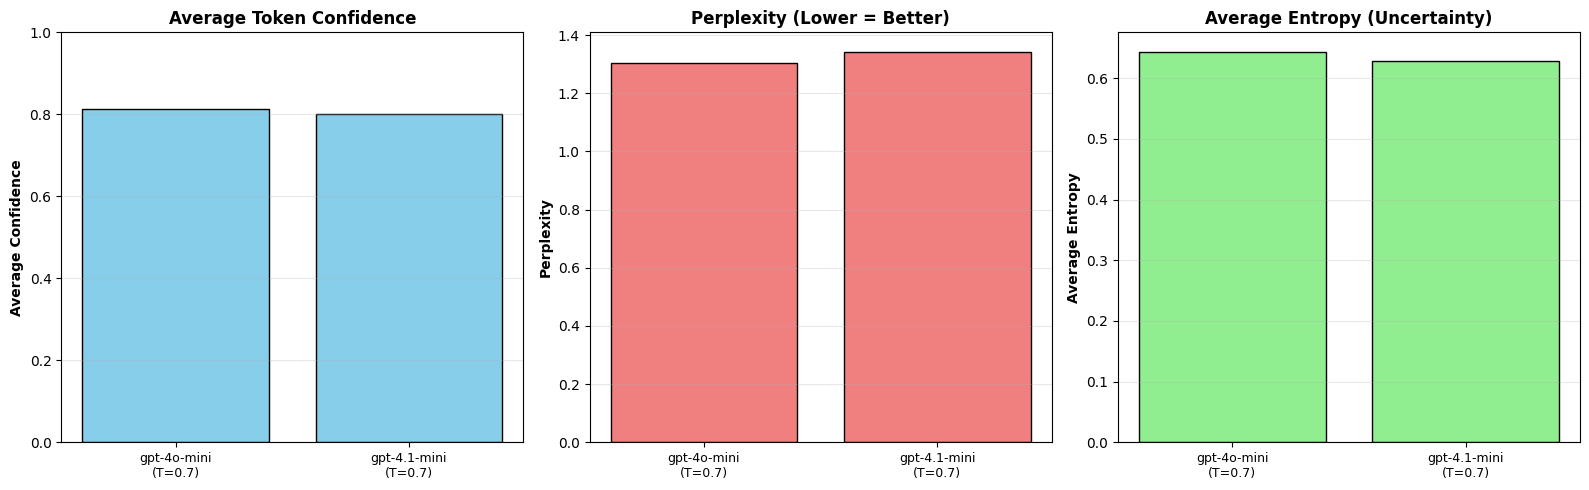

✅ Comparison complete!


In [17]:
# ========================================
# 📊 Metrics Comparison Visualization
# ========================================

print("📊 Creating metrics comparison chart...")
fig = create_metrics_comparison(model_results)
plt.show()
print("✅ Comparison complete!")

---

## 🎨 Interactive Gradio Interface

> Launch the web-based UI for easy experimentation with prompts and models

**Features:**
- 🔍 **Tab 1**: Analyze a single prompt with visualizations
- 📊 **Tab 2**: Compare two different prompts
- 🤖 **Tab 3**: Compare the same prompt across different models

In [18]:
# ========================================
# 🔧 Gradio Interface Functions
# ========================================

def analyze_single_prompt(prompt, model, max_tokens, temperature):
    """Analyze a single prompt and return visualizations."""
    if not prompt.strip():
        return None, None, "⚠️ Please enter a prompt."
    
    try:
        predictor = TokenPredictor(model)
        result = predictor.predict_tokens(prompt, int(max_tokens), float(temperature))
        
        # Create visualizations
        fig_heatmap = create_probability_heatmap(result)
        fig_alternatives = create_alternatives_plot(result, token_index=0)
        
        # Format metrics
        metrics_text = f"""### ✨ Generated Text:
"{result['generated_text']}"

### 📊 Metrics:
| Metric | Value |
|--------|-------|
| **Token Count** | {result['metrics']['token_count']} |
| **Average Confidence** | {result['metrics']['avg_confidence']:.4f} |
| **Perplexity** | {result['metrics']['perplexity']:.4f} |
| **Average Entropy** | {result['metrics']['avg_entropy']:.4f} |
| **Low Confidence Tokens** | {result['metrics']['low_confidence_tokens']} ({result['metrics']['low_confidence_pct']:.1f}%) |
| **Min Probability** | {result['metrics']['min_probability']:.4f} |
| **Max Probability** | {result['metrics']['max_probability']:.4f} |
"""
        
        return fig_heatmap, fig_alternatives, metrics_text
    
    except Exception as e:
        return None, None, f"❌ Error: {str(e)}"


def compare_multiple_prompts(prompt1, prompt2, model, max_tokens, temperature):
    """Compare two prompts side-by-side."""
    if not prompt1.strip() or not prompt2.strip():
        return None, "⚠️ Please enter both prompts."
    
    try:
        prompts = [prompt1, prompt2]
        results = compare_prompts(prompts, model, int(max_tokens), float(temperature))
        
        # Create comparison visualization
        fig = create_metrics_comparison(results)
        
        # Format comparison text
        comparison_text = ""
        for i, result in enumerate(results, 1):
            comparison_text += f"""### 📝 Prompt {i}:
**Input**: "{result['prompt']}"

**Generated**: "{result['generated_text']}"

| Metric | Value |
|--------|-------|
| **Avg Confidence** | {result['metrics']['avg_confidence']:.4f} |
| **Perplexity** | {result['metrics']['perplexity']:.4f} |
| **Token Count** | {result['metrics']['token_count']} |

---

"""
        
        return fig, comparison_text
    
    except Exception as e:
        return None, f"❌ Error: {str(e)}"


def compare_multiple_models(prompt, model1, model2, max_tokens, temperature):
    """Compare same prompt across different models."""
    if not prompt.strip():
        return None, "⚠️ Please enter a prompt."
    
    try:
        models = [model1, model2]
        results = compare_models(prompt, models, int(max_tokens), float(temperature))
        
        # Create comparison visualization
        fig = create_metrics_comparison(results)
        
        # Format comparison text
        comparison_text = f"""### 📝 Prompt:
"{prompt}"

---

"""
        for result in results:
            comparison_text += f"""### 🤖 {result['model']}:
**Generated**: "{result['generated_text']}"

| Metric | Value |
|--------|-------|
| **Avg Confidence** | {result['metrics']['avg_confidence']:.4f} |
| **Perplexity** | {result['metrics']['perplexity']:.4f} |
| **Token Count** | {result['metrics']['token_count']} |
| **Avg Entropy** | {result['metrics']['avg_entropy']:.4f} |

---

"""
        
        return fig, comparison_text
    
    except Exception as e:
        return None, f"❌ Error: {str(e)}"

In [ ]:
# ========================================
# 🚀 Launch Gradio Interface
# ========================================

AVAILABLE_MODELS = [
    "gpt-4o-mini",
    "gpt-4.1-mini",
    "gpt-3.5-turbo",
    "gpt-4o"
]

with gr.Blocks(title="Prompt Testing Playground", theme=gr.themes.Soft()) as demo:
    gr.Markdown(
        """
        # 🧪 Prompt Testing Playground
        
        > An interactive tool for testing, comparing, and visualizing LLM prompts across multiple models
        
        ---
        
        ### ✨ Features:
        - 📊 Analyze token-by-token predictions with probability visualization
        - 🔄 Compare multiple prompts or models side-by-side
        - 📈 View detailed metrics (confidence, perplexity, entropy)
        - 🔍 Explore alternative token paths
        
        **💡 Inspired by Week 3's visualizer.py**
        """
    )
    
    with gr.Tabs():
        # Tab 1: Single Prompt Analysis
        with gr.Tab("🔍 Analyze Prompt"):
            gr.Markdown("### Analyze a single prompt and visualize token predictions")
            
            with gr.Row():
                with gr.Column():
                    single_prompt = gr.Textbox(
                        label="💬 Prompt",
                        placeholder="Enter your prompt here...",
                        lines=4
                    )
                    with gr.Row():
                        single_model = gr.Dropdown(
                            choices=AVAILABLE_MODELS,
                            value="gpt-4o-mini",
                            label="🤖 Model"
                        )
                        single_max_tokens = gr.Slider(
                            minimum=10,
                            maximum=200,
                            value=50,
                            step=10,
                            label="📏 Max Tokens"
                        )
                        single_temperature = gr.Slider(
                            minimum=0.0,
                            maximum=1.0,
                            value=0.7,
                            step=0.1,
                            label="🌡️ Temperature"
                        )
                    analyze_btn = gr.Button("🚀 Analyze", variant="primary", size="lg")
            
            single_metrics = gr.Markdown(label="📊 Metrics")
            single_heatmap = gr.Plot(label="📈 Token Probability Heatmap")
            single_alternatives = gr.Plot(label="🔀 Alternative Tokens (Position 1)")
            
            analyze_btn.click(
                fn=analyze_single_prompt,
                inputs=[single_prompt, single_model, single_max_tokens, single_temperature],
                outputs=[single_heatmap, single_alternatives, single_metrics]
            )
            
            gr.Examples(
                examples=[
                    ["In one sentence, describe the color orange to someone who has never been able to see.", "gpt-4o-mini", 50, 0.7],
                    ["Write a haiku about programming.", "gpt-4.1-mini", 30, 0.8],
                    ["Explain quantum computing to a 5-year-old.", "gpt-4o-mini", 50, 0.5],
                ],
                inputs=[single_prompt, single_model, single_max_tokens, single_temperature]
            )
        
        # Tab 2: Compare Prompts
        with gr.Tab("📊 Compare Prompts"):
            gr.Markdown("### Compare two different prompts using the same model")
            
            with gr.Row():
                prompt_a = gr.Textbox(
                    label="💬 Prompt A",
                    placeholder="Enter first prompt...",
                    lines=3
                )
                prompt_b = gr.Textbox(
                    label="💬 Prompt B",
                    placeholder="Enter second prompt...",
                    lines=3
                )
            
            with gr.Row():
                prompts_model = gr.Dropdown(
                    choices=AVAILABLE_MODELS,
                    value="gpt-4o-mini",
                    label="🤖 Model"
                )
                prompts_max_tokens = gr.Slider(10, 200, 50, step=10, label="📏 Max Tokens")
                prompts_temperature = gr.Slider(0.0, 1.0, 0.7, step=0.1, label="🌡️ Temperature")
            
            compare_prompts_btn = gr.Button("🔄 Compare Prompts", variant="primary", size="lg")
            
            prompts_comparison = gr.Markdown(label="📊 Comparison Results")
            prompts_plot = gr.Plot(label="📈 Metrics Comparison")
            
            compare_prompts_btn.click(
                fn=compare_multiple_prompts,
                inputs=[prompt_a, prompt_b, prompts_model, prompts_max_tokens, prompts_temperature],
                outputs=[prompts_plot, prompts_comparison]
            )
            
            gr.Examples(
                examples=[
                    ["Write a short poem about the ocean.", "Compose a brief verse about the sea.", "gpt-4o-mini", 50, 0.7],
                    ["Explain AI in simple terms.", "Describe artificial intelligence for beginners.", "gpt-4.1-mini", 50, 0.5],
                ],
                inputs=[prompt_a, prompt_b, prompts_model, prompts_max_tokens, prompts_temperature]
            )
        
        # Tab 3: Compare Models
        with gr.Tab("🤖 Compare Models"):
            gr.Markdown("### Compare the same prompt across different models")
            
            models_prompt = gr.Textbox(
                label="💬 Prompt",
                placeholder="Enter prompt to test across models...",
                lines=4
            )
            
            with gr.Row():
                model_a = gr.Dropdown(
                    choices=AVAILABLE_MODELS,
                    value="gpt-4o-mini",
                    label="🤖 Model A"
                )
                model_b = gr.Dropdown(
                    choices=AVAILABLE_MODELS,
                    value="gpt-4.1-mini",
                    label="🤖 Model B"
                )
            
            with gr.Row():
                models_max_tokens = gr.Slider(10, 200, 50, step=10, label="📏 Max Tokens")
                models_temperature = gr.Slider(0.0, 1.0, 0.7, step=0.1, label="🌡️ Temperature")
            
            compare_models_btn = gr.Button("🔬 Compare Models", variant="primary", size="lg")
            
            models_comparison = gr.Markdown(label="📊 Comparison Results")
            models_plot = gr.Plot(label="📈 Metrics Comparison")
            
            compare_models_btn.click(
                fn=compare_multiple_models,
                inputs=[models_prompt, model_a, model_b, models_max_tokens, models_temperature],
                outputs=[models_plot, models_comparison]
            )
            
            gr.Examples(
                examples=[
                    ["Explain machine learning in one sentence.", "gpt-4o-mini", "gpt-4.1-mini", 50, 0.5],
                    ["Write a creative opening line for a story.", "gpt-4o-mini", "gpt-4o", 30, 0.9],
                ],
                inputs=[models_prompt, model_a, model_b, models_max_tokens, models_temperature]
            )
    
    gr.Markdown(
        """
        ---
        
        ## 📚 About the Metrics
        
        | Metric | Description | Good Range |
        |--------|-------------|------------|
        | **Average Confidence** | Mean probability of selected tokens | Higher = More confident (>0.7 is good) |
        | **Perplexity** | How "surprised" the model is | Lower = Better (<10 is good) |
        | **Entropy** | Uncertainty in predictions | Varies by task (creative = higher) |
        | **Low Confidence Tokens** | Tokens with probability < 50% | Lower % = Better |
        
        ---
        
        ## 💡 Tips for Best Results
        
        | Temperature | Use Case | Example |
        |-------------|----------|---------|
        | **0.0 - 0.3** | Factual, deterministic | Code generation, factual Q&A |
        | **0.5 - 0.7** | Balanced (default) | General purpose tasks |
        | **0.8 - 1.0** | Creative, diverse | Story writing, brainstorming |
        
        ---
        
        **👨‍💻 Week 3 Contribution by dc_dalin** | **💡 Inspired by visualizer.py**
        """
    )

# ========================================
# 🎬 Launch the Interface
# ========================================

print("\n" + "=" * 60)
print("🎨 LAUNCHING GRADIO INTERFACE")
print("=" * 60)
print("🌐 The interface will open in your browser")
print("💡 Use Ctrl+C to stop the server")
print("=" * 60 + "\n")

demo.launch(share=False, debug=True)


🎨 LAUNCHING GRADIO INTERFACE
🌐 The interface will open in your browser
💡 Use Ctrl+C to stop the server

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


---

## 💾 Advanced: Export Results to JSON

> Save your comparison results for further analysis or documentation

In [ ]:
def export_results_to_json(results: List[Dict], filename: str = "prompt_test_results.json"):
    """Export comparison results to JSON file."""
    with open(filename, 'w') as f:
        json.dump(results, f, indent=2)
    print(f"✅ Results exported to {filename}")

# ========================================
# 📝 Example Usage
# ========================================

# Uncomment to export your results:
# export_results_to_json(model_results, "model_comparison.json")

print("💡 Use export_results_to_json() to save your comparison results")

---

## 📖 Example Use Cases

> Practical examples for common prompt engineering and model selection scenarios

### 🔧 1. Prompt Engineering
Test different phrasings of the same question to see which gets better responses:

```python
prompts = [
    "Explain quantum computing",
    "Explain quantum computing in simple terms",
    "Explain quantum computing to a beginner"
]
results = compare_prompts(prompts)

# Look for:
# - Highest average confidence
# - Lowest perplexity
# - Most appropriate response
```

---

### ⚖️ 2. Model Selection
Choose the best model for your use case:

```python
models = ["gpt-4o-mini", "gpt-4.1-mini", "gpt-4o"]
results = compare_models("Your critical prompt", models)

# Consider:
# - gpt-4o-mini: Fastest, lowest cost
# - gpt-4.1-mini: Better reasoning
# - gpt-4o: Best quality, highest cost
```

---

### 🔬 3. Understanding Token Predictions
See how confident the model is at each step and identify potential issues:

```python
predictor = TokenPredictor()
result = predictor.predict_tokens("Your prompt")

# Check for:
# - Low confidence tokens (might indicate problems)
# - High perplexity (model struggling)
# - Uncertainty patterns
```

---

## 🎓 Learning Outcomes

By using this playground, you'll understand:

- ✅ How LLMs predict tokens step-by-step
- ✅ The role of temperature in generation
- ✅ How to optimize prompts for better results
- ✅ Differences between model capabilities
- ✅ Interpreting confidence and uncertainty metrics

---

**🎉 You're all set! Start experimenting with the Gradio interface above!**

**👨‍💻 Week 3 Contribution by dc_dalin** | **📅 2024**